# 분석2 : CLI 에 따른 lab data 분석 

## TOC
* [데이터 탐색](#데이터-탐색)
    * [평균 및 분포](#평균-및-분포-확인)
    * [정규성 검정](#정규성-검정)
    * [로그데이터](#로그-데이터-확인)
    * [변수간 상관관계](#상관관계-파악)
    
* [데이터 검정](#Lab-data-검정)
    * [Wilcox test](#Wilcox-test)
    * [log의 Wilcox test](#log에-대한-wilcox-test)
    * [교란 변수 고정 분석](#교란-변수-제거)
    * [교란 변수 고정 분석(로그)](#로그-변수에-대한-교란변수-고정)

* [Logistic regression](#로지스틱-회귀)
    * [DM+alcohol+statin+HTN](#DM+alcohol+statin+HTN-모형에-추가)
        * [결과](#결과1)
    * [DM+alcohol+statin](#DM+alcohol+statin-모형에-추가)
        * [결과](#결과2)
    * [로그변수에 대한 회귀](#로그변수에-대한-로지스틱-회귀)
    * [모형적합](#모형-적합)
        * [적합 결과](#적합-결과)
* [요약](#요약)


#### 2) 분석 2

CLI 유무에 따른 lab data (Average CFU, VEGF, VEGF/CD34, CD34, SDF-1, VEGF) 의 차이를 보는 것이 분석 2 입니다.

즉 [Group 3+4+5]와 [Group 6+7+8] 의 상기 변수의 차이를 통계적으로 분석하는 것이 필요합니다. 

### CLI 집단과 비CLI 집단 사이의 lab 수치 비교

Average CFU, VEGF, VEGF/CD34, CD34, SDF-1, VEGF : 연속형 데이터
    
    => t-test or wilcoxon test

In [16]:
#데이터 불러오기
library(xlsx)
library(dplyr)

data <- read.xlsx("../EPCinCKD_201802.xlsx", sheetIndex = 1)
data <- data[1:150,-c(1,2)]
colnames(data)[c(7, 13, 15, 16, 22)] <- c("HTN", "statin", "obesity", "PAD", "CD34.All")
data <- data %>% mutate( CLI = as.numeric(Group>=5))
data <- data[complete.cases(data),]
dim(data)

[1] 133  25

---
# 데이터 탐색
---

CLI 유무를 기준으로 나눈 집단에서 

Average CFU, VEGF, VEGF/CD34, CD34, SDF-1, VEGF 수치 확인


## 평균 및 분포 확인

### 평균 확인

In [17]:
# CLI 그룹별 비교

cat("\n<CLI 그룹에 따른 Lab data 비교>\n")
cat("\n<평균>\n")
data %>% 
    group_by( CLI ) %>%
    summarise( mean.Average.CFU = mean(Average.CFU, na.rm = T),
            mean.VEGF = mean(VEGF, na.rm = T),
            mean.CD34.VEGF = mean(CD34.VEGF, na.rm=T),
            mean.CD34 = mean(CD34, na.rm = T),
            mean.VEGF.All = mean(VEGF.All, na.rm = T),
            mean.CD34.All = mean(CD34.All, na.rm = T),
            mean.VEGF.1 = mean(VEGF.1, na.rm = T),
            mean.SDF.1 = mean(SDF.1, na.rm = T)
             ) %>%
    mutate_if(is.numeric, funs(round(., 2)))


cat("\n<표준편차>\n")
data %>% 
    group_by( CLI ) %>%
    summarise( std.Average.CFU = sqrt(var(Average.CFU, na.rm = T)),
            std.VEGF = sqrt(var(VEGF, na.rm = T)),
            std.CD34.VEGF = sqrt(var(CD34.VEGF, na.rm=T)),
            std.CD34 = sqrt(var(CD34, na.rm = T)),
            std.VEGF.All = sqrt(var(VEGF.All, na.rm = T)),
            std.CD34.All = sqrt(var(CD34.All, na.rm = T)),
            std.VEGF.1 = sqrt(var(VEGF.1, na.rm = T)),
            std.SDF.1 = sqrt(var(SDF.1, na.rm = T))
             ) %>%
    mutate_if(is.numeric, funs(round(., 2)))


<CLI 그룹에 따른 Lab data 비교>

<평균>


CLI,mean.Average.CFU,mean.VEGF,mean.CD34.VEGF,mean.CD34,mean.VEGF.All,mean.CD34.All,mean.VEGF.1,mean.SDF.1
0,5.21,6.74,0.32,0.11,7.05,0.42,65.2,2388.11
1,4.85,3.61,0.32,0.46,3.93,0.78,121.8,3241.81



<표준편차>


CLI,std.Average.CFU,std.VEGF,std.CD34.VEGF,std.CD34,std.VEGF.All,std.CD34.All,std.VEGF.1,std.SDF.1
0,0.87,4.13,0.27,0.29,4.21,0.41,48.97,520.18
1,0.77,4.93,0.38,1.50,4.98,1.81,124.03,989.49


표본표준편차에 비하여 평균이 큰 차이가 나 보이는 녀석들은 없다. SDF.1 정도?

### 분포 확인



<CLI 그룹에 따른 Lab data 시각화>


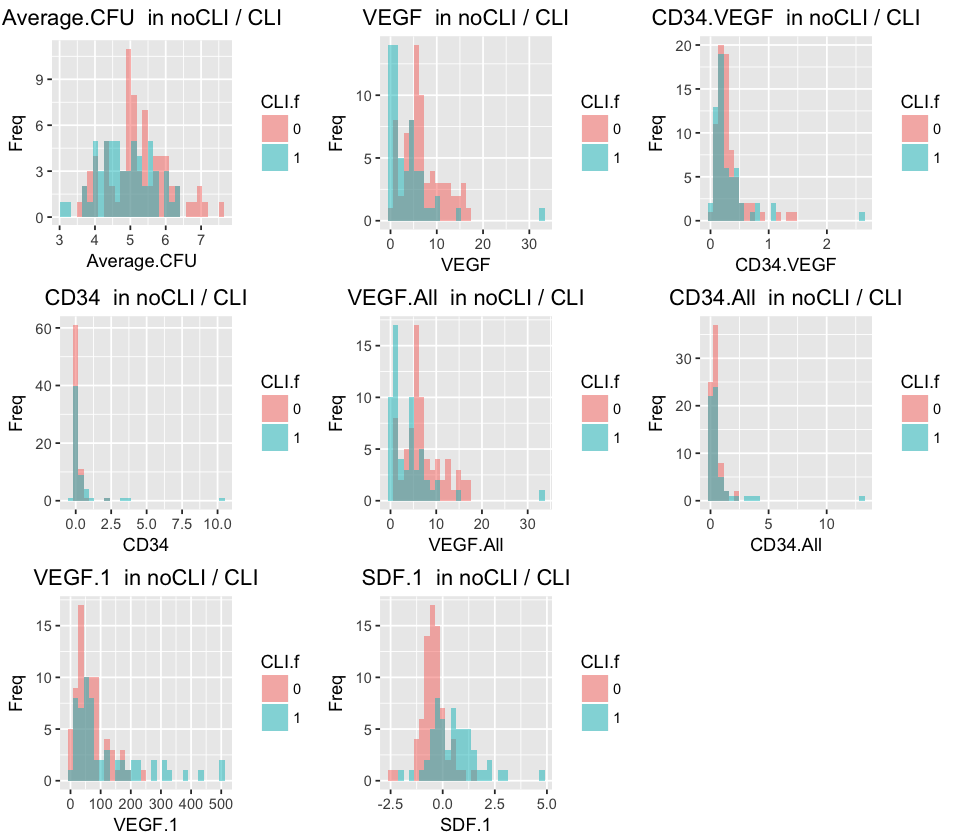

In [31]:
# 각각의 값에 대한 그래프 그리기
library(ggplot2)
library(gridExtra)
plots <- list()

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){

    p<- data %>% 
        mutate(CLI.f = as.factor(CLI)) %>%
        ggplot(aes_string(x=key, fill = "CLI.f")) +
        geom_histogram(alpha=0.5, position="identity",bins = 30, na.rm = T) +  
        ggtitle(paste(key, " in noCLI / CLI")) +
        labs(x=key, y="Freq") +
        theme(plot.title = element_text(hjust = 0.5))
    
    plots[[key]] <- p
}

options(repr.plot.width=8, repr.plot.height=7)
cat("\n\n<CLI 그룹에 따른 Lab data 시각화>\n")
grid.arrange(grobs=plots, ncol=3)

## 정규성 검정

### QQPlot



<CLI 그룹에 따른 Lab data 정규성 시각화>


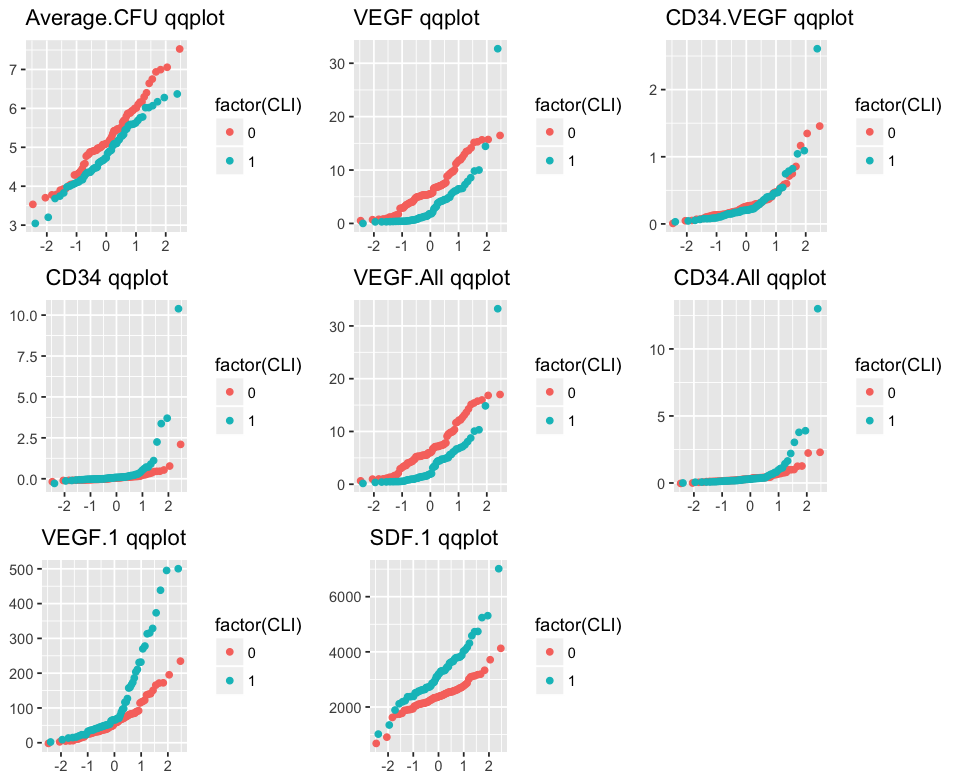

In [52]:
# 정규성 그래프

par(mfrow = c(3, 3))

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    p <- data %>% ggplot(aes_string(sample = key)) + 
        stat_qq(aes(color=factor(CLI))) + 
        ggtitle(paste(key, "qqplot")) + 
        theme(
          axis.title.x=element_blank(), 
          axis.title.y=element_blank())

    plots[[key]] <- p
}
options(repr.plot.width=8, repr.plot.height=6.5)
cat("\n\n<CLI 그룹에 따른 Lab data 정규성 시각화>\n")
grid.arrange(grobs=plots, ncol=3)

Outlier 점들이 몇개 있는 것으로 보이나, 없애더라도 양상은 비슷하다. 

CFU 정도 직선으로 보인다.

### 검정 값

In [50]:
cat("\n<CLI 그룹에 따른 Lab data, 정규성 검정 결과>\n")
data %>% 
    group_by( CLI ) %>%
    summarise( Average.CFU = shapiro.test(Average.CFU)$p.value,
            VEGF = shapiro.test(VEGF)$p.value,
            CD34.VEGF = shapiro.test(CD34.VEGF)$p.value,
            CD34 = shapiro.test(CD34)$p.value,
            VEGF.All = shapiro.test(VEGF.All)$p.value,
            CD34.All = shapiro.test(CD34.All)$p.value,
            VEGF.1 = shapiro.test(VEGF.1)$p.value,
            SDF.1 = shapiro.test(SDF.1)$p.value
             ) %>%
    mutate_if(is.numeric, funs(round(., 4)))


<CLI 그룹에 따른 Lab data, 정규성 검정 결과>


CLI,Average.CFU,VEGF,CD34.VEGF,CD34,VEGF.All,CD34.All,VEGF.1,SDF.1
0,0.3108,0.0011,0,0,0.0013,0,0,0.0027
1,0.6708,0.0000,0,0,0.0000,0,0,0.0071


**정규성을 만족하는건 CFU 뿐이다. **

In [111]:
cat("\nAverage CFU 등분산성 검정\n")
pv <- var.test(data$Average.CFU ~ data$CLI)$p.value
cat("  p-value:", round(pv,3))


Average CFU 등분산성 검정
  p-value: 0.33

## 로그 데이터 확인

In [21]:
cat("\n<CLI 그룹에 따른 로그변환 Lab data, 정규성 검정 결과>\n")
data %>% 
    group_by( CLI ) %>%
    summarise( log.Average.CFU = shapiro.test(log(Average.CFU))$p.value,
            log.VEGF = shapiro.test(log(VEGF))$p.value,
            log.CD34.VEGF = shapiro.test(log(CD34.VEGF))$p.value,
            log.CD34 = shapiro.test(log(CD34))$p.value,
            log.VEGF.All = shapiro.test(log(VEGF.All))$p.value,
            log.CD34.All = shapiro.test(log(CD34.All))$p.value,
            log.VEGF.1 = shapiro.test(log(VEGF.1))$p.value,
            log.SDF.1 = shapiro.test(log(SDF.1))$p.value
             ) %>%
    mutate_if(is.numeric, funs(round(., 4)))


<CLI 그룹에 따른 로그변환 Lab data, 정규성 검정 결과>


Warning message in log(CD34):
“NaN이 생성되었습니다”Warning message in log(CD34):
“NaN이 생성되었습니다”Warning message in log(CD34.All):
“NaN이 생성되었습니다”Warning message in log(VEGF.1):
“NaN이 생성되었습니다”

CLI,log.Average.CFU,log.VEGF,log.CD34.VEGF,log.CD34,log.VEGF.All,log.CD34.All,log.VEGF.1,log.SDF.1
0,0.5269,1e-04,0.0014,0.6791,0.0002,0.5935,0.0019,0.000
1,0.3255,3e-04,0.7956,0.1219,0.1348,0.0000,0.1282,0.026


log 변환해도 정규성을 따른다고 볼만한 변수는 **CFU 와 CD 34** 뿐이다. 

***그런데 검사 값이 음수가 나와서 warning 이 생기는데, 그게 가능한 것인가..?***

위 결과를 기반으로 하면 대부분의 변수에 wilcoxon rank sum 검정을 실시해야하고, 

CFU 와 log(CD 34) 정도는 t-test 를 시도해볼만한 가치가 있겠다. 

## 상관관계 파악

변수들간의 상관관계를 파악해보자. 

,Average.CFU,VEGF,VEGF.All,CD34.VEGF,CD34,CD34.All,VEGF.1,SDF.1
Average.CFU,1,0.24,0.23,-0.14,-0.21,-0.21,-0.09,-0.32
VEGF,NA,1.00,1.00,0.16,-0.11,-0.05,-0.10,-0.23
VEGF.All,NA,NA,1.00,0.23,-0.07,0.00,-0.08,-0.22
CD34.VEGF,NA,NA,NA,1.00,0.60,0.75,0.23,0.09
CD34,NA,NA,NA,NA,1.00,0.98,0.28,0.12
CD34.All,NA,NA,NA,NA,NA,1.00,0.29,0.12
VEGF.1,NA,NA,NA,NA,NA,NA,1.00,0.41
SDF.1,NA,NA,NA,NA,NA,NA,NA,1.00


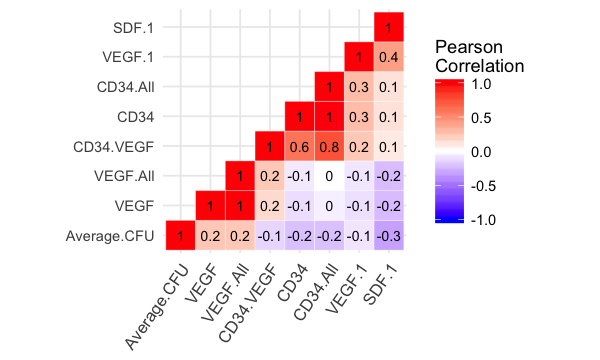

In [54]:
# 상관 계수를 살펴보자 

library(reshape2)

cormat <- round(cor(data[c(17, 18,21, 19, 20 ,22, 23, 24)], use = 'complete.obs'),2)
cormat[lower.tri(cormat)]<- NA
cormat

options(repr.plot.width=5, repr.plot.height=3)
melted_cormat <- melt(cormat, na.rm = TRUE)
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
    geom_tile(color = "white")+
    scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                         midpoint = 0, limit = c(-1,1), space = "Lab", 
                         name="Pearson\nCorrelation") +
    theme_minimal()+ 
    theme(axis.text.x = element_text(angle = 55, vjust = 1, 
                                     size = 10, hjust = 1) , 
          axis.title.x=element_blank(), 
          axis.title.y=element_blank())+
    coord_fixed() + geom_text(aes(Var2, Var1, label = round(value,1)), color = "black", size = 3)

위 결과를 봤을 때, 
- CD34
- CD34.All
- CD34.VEGF

는 상관 관계가 매우 높아, 거의 한 변수로 봐도 될 정도

- VEGF
- VEGF.All

도 마찬가지 

log 에 대해서도 살펴보면

Warning message in FUN(X[[i]], ...):
“NaN이 생성되었습니다”Warning message in FUN(X[[i]], ...):
“NaN이 생성되었습니다”Warning message in FUN(X[[i]], ...):
“NaN이 생성되었습니다”

,Average.CFU,VEGF,VEGF.All,CD34.VEGF,CD34,CD34.All,VEGF.1,SDF.1
Average.CFU,1,0.17,0.18,-0.12,-0.10,-0.18,-0.25,-0.37
VEGF,NA,1.00,0.96,0.30,-0.03,0.08,-0.14,-0.33
VEGF.All,NA,NA,1.00,0.41,0.06,0.19,-0.16,-0.32
CD34.VEGF,NA,NA,NA,1.00,0.45,0.78,0.04,0.09
CD34,NA,NA,NA,NA,1.00,0.84,0.03,0.10
CD34.All,NA,NA,NA,NA,NA,1.00,0.06,0.14
VEGF.1,NA,NA,NA,NA,NA,NA,1.00,0.38
SDF.1,NA,NA,NA,NA,NA,NA,NA,1.00


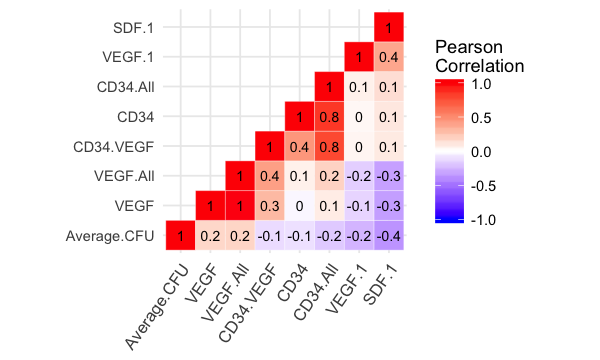

In [55]:
# 상관 계수를 살펴보자 

library(reshape2)

cormat <- round(cor(log(data[c(17, 18, 21, 19, 20 ,22, 23, 24)] + 1e-5), use = 'complete.obs'),2)
cormat[lower.tri(cormat)]<- NA
cormat

options(repr.plot.width=5, repr.plot.height=3)
melted_cormat <- melt(cormat, na.rm = TRUE)
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
    geom_tile(color = "white")+
    scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                         midpoint = 0, limit = c(-1,1), space = "Lab", 
                         name="Pearson\nCorrelation") +
    theme_minimal()+ 
    theme(axis.text.x = element_text(angle = 55, vjust = 1, 
                                     size = 10, hjust = 1) , 
          axis.title.x=element_blank(), 
          axis.title.y=element_blank())+
    coord_fixed() + geom_text(aes(Var2, Var1, label = round(value,1)), color = "black", size = 3)

거의 비슷한 결과다. 

* CD34 = CD34.All ~=CD34.VEGF
* VEGF = VEGF.All 
* VEGF.1 ~= SDF.1 
* Average.CFU

이정도로 변수들이 그룹지어지는 것으로 보인다. 

---
# Lab data 검정
---

위 결과를 토대로 
각 지표들이 차이가 있는지 확인해보자. 

Average.CFU 는 t-test, 이외의 것들은 wilcoxon test

## Wilcox test

In [114]:
# Wilcoxon rank sum test for lab data

pv <- t.test(Average.CFU ~ CLI, data=data)$p.value
cat("\n Average.CFU t-test : p-value =", round(pv,3))

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    
    test <- wilcox.test(as.formula(paste(key,"~ CLI")), data = data)
    cat("\n", key, "result :", "p-value =", round(test$p.value,4), '\n')
}



 Average.CFU t-test : p-value = 0.012
 Average.CFU result : p-value = 0.0302 

 VEGF result : p-value = 0 

 CD34.VEGF result : p-value = 0.365 

 CD34 result : p-value = 0.1441 

 VEGF.All result : p-value = 0 

 CD34.All result : p-value = 0.7911 

 VEGF.1 result : p-value = 0.0248 

 SDF.1 result : p-value = 0 


유의미한 결과 :
- Average CFU
- VEGF
- VEGF.All
- VEGF.1
- SDF.1

## log에 대한 wilcox test

In [120]:
# log 값에 대한 분석 

pv <- t.test(log(Average.CFU) ~ CLI, data=data)$p.value
cat("\n Average.CFU t-test : p-value =", round(pv,3))

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    test <- wilcox.test(as.formula(paste("log(",key,")~ CLI")), data = data)
    cat("\n", key, "result :", "p-value =", round(test$p.value,4), '\n')
}

pv <- t.test(log(CD34) ~ CLI, data=data)$p.value
cat("\n CD34 t-test : p-value =", round(pv,3))


 Average.CFU t-test : p-value = 0.015
 Average.CFU result : p-value = 0.0302 

 VEGF result : p-value = 0 

 CD34.VEGF result : p-value = 0.365 


Warning message in log(CD34):
“NaN이 생성되었습니다”Warning message in wilcox.test.default(x = c(0.741937344729377, -0.83355933427669, :
“cannot compute exact p-value with ties”


 CD34 result : p-value = 0.4372 

 VEGF.All result : p-value = 0 


Warning message in log(CD34.All):
“NaN이 생성되었습니다”


 CD34.All result : p-value = 0.5867 


Warning message in log(VEGF.1):
“NaN이 생성되었습니다”


 VEGF.1 result : p-value = 0.0329 

 SDF.1 result : p-value = 0 


Warning message in log(CD34):
“NaN이 생성되었습니다”


 CD34 t-test : p-value = 0.487

앞과 같은 결과 

**Average CFU 와 VEGF.1 은 경계수준**

**VEGF, VEGF.All, SDF.1 은 꽤나 유의미**

혹시 이것이 앞서 demographic data 의 차이로 인한 것은 아닌지 한 번 살펴보자. 

DM + alcohol + statin (+ HTN ) 이 녀석들에 대한 것들을 고정으로 두고, 분석을 실시해보자. 

## 교란 변수 제거

### 분리된 집단의 수
그런데 분리된 집단의 수는 다음과 같다. 

In [70]:
df %>% 
    mutate(DM = as.factor(DM), alcohol = as.factor(alcohol), statin=as.factor(statin)) %>% 
    group_by(DM, alcohol, statin) %>% 
    summarise(CLI1 = sum(CLI==1), CLI0 = sum(CLI==0))

DM,alcohol,statin,CLI1,CLI0
0,0,0,10,13
0,0,1,6,22
0,1,0,2,6
0,1,1,1,4
1,0,0,31,5
1,0,1,6,11
1,1,0,0,5
1,1,1,1,8


일부 집단에 대해서는 개체수가 너무 적어 검정이 어려울 것으로 생각된다. 

따라서 선별적으로 개체수가 적절한 테이터에 대해서만 분석을 먼저 돌려보자 

DM, alcohol, statin = (0,0,0), (0,0,1),(1,0,0),(1,0,1)

을 대상으로 해보자

#### (0,0,0)

In [188]:
tmp <- data %>% filter(DM == 0, alcohol==0, statin==0)

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    test <- wilcox.test(as.formula(paste(key,"~ CLI")), data = tmp)
    cat("\n", key, "result : p-value =", round(test$p.value, 4), '\n')
}


 Average.CFU result : p-value = 0.4833 

 VEGF result : p-value = 0.7844 


Warning message in wilcox.test.default(x = c(0.19, 0.1715, 0.0835, 0.047, 0.294, :
“cannot compute exact p-value with ties”


 CD34.VEGF result : p-value = 0.9259 


Warning message in wilcox.test.default(x = c(2.1, 0.4345, -0.0175, -0.079, -0.1035, :
“cannot compute exact p-value with ties”


 CD34 result : p-value = 0.8281 

 VEGF.All result : p-value = 0.7844 

 CD34.All result : p-value = 0.3758 

 VEGF.1 result : p-value = 0.1151 

 SDF.1 result : p-value = 0.0358 


#### (0,0,1)

In [190]:
tmp <- data %>% filter(DM == 0, alcohol==0, statin==1)

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    test <- wilcox.test(as.formula(paste(key,"~ CLI")), data = tmp)
    cat("\n", key, "result : p-value =", round(test$p.value, 4), '\n')
}


 Average.CFU result : p-value = 0.0053 

 VEGF result : p-value = 0.0331 

 CD34.VEGF result : p-value = 0.6824 

 CD34 result : p-value = 0.6426 

 VEGF.All result : p-value = 0.0386 

 CD34.All result : p-value = 0.6426 

 VEGF.1 result : p-value = 0.7642 

 SDF.1 result : p-value = 0.0016 


#### (1,0,0)

In [193]:
tmp <- data %>% filter(DM == 1, alcohol==0, statin==0)

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    test <- wilcox.test(as.formula(paste(key,"~ CLI")), data = tmp)
    cat("\n", key, "result : p-value =", round(test$p.value, 4), '\n')
}


 Average.CFU result : p-value = 0.286 

 VEGF result : p-value = 0.0213 

 CD34.VEGF result : p-value = 0.1965 

 CD34 result : p-value = 0.5598 

 VEGF.All result : p-value = 0.0161 

 CD34.All result : p-value = 0.286 

 VEGF.1 result : p-value = 0.5027 

 SDF.1 result : p-value = 0.0186 


#### (1,0,1)

In [196]:
tmp <- data %>% filter(DM == 1, alcohol==0, statin==1)

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    test <- wilcox.test(as.formula(paste(key,"~ CLI")), data = tmp)
    cat("\n", key, "result : p-value =", round(test$p.value, 4), '\n')
}


 Average.CFU result : p-value = 0.6605 

 VEGF result : p-value = 0.1215 

 CD34.VEGF result : p-value = 0.5249 

 CD34 result : p-value = 0.9612 

 VEGF.All result : p-value = 0.1215 

 CD34.All result : p-value = 0.7325 

 VEGF.1 result : p-value = 0.5249 

 SDF.1 result : p-value = 0.3502 


대략 유의미하게 나오는 녀석들은 SDF.1, VEGF(.All), Average.CFU 정도 임을 알 수 있다. 

log 에 대해서도 대략 비슷하게 나올 것이라고 생각해볼 수 있다. 

## 로그 변수에 대한 교란변수 고정

#### (0,0,0)

In [127]:
tmp <- data %>% filter(DM == 0, alcohol==0, statin==0)

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    test <- wilcox.test(as.formula(paste("log(",key,")~ CLI")), data = tmp)
    cat("\n", key, "result : p-value =", round(test$p.value, 4), '\n')
}


 Average.CFU result : p-value = 0.4833 

 VEGF result : p-value = 0.7844 


Warning message in wilcox.test.default(x = c(-1.66073120682165, -1.76317201237614, :
“cannot compute exact p-value with ties”


 CD34.VEGF result : p-value = 0.9259 


Warning message in log(CD34):
“NaN이 생성되었습니다”


 CD34 result : p-value = 0.9333 

 VEGF.All result : p-value = 0.7844 


Warning message in log(CD34.All):
“NaN이 생성되었습니다”


 CD34.All result : p-value = 0.203 

 VEGF.1 result : p-value = 0.1151 

 SDF.1 result : p-value = 0.0358 


#### (0,0,1)

In [128]:
tmp <- data %>% filter(DM == 0, alcohol==0, statin==1)

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    test <- wilcox.test(as.formula(paste("log(",key,")~ CLI")), data = tmp)
    cat("\n", key, "result : p-value =", round(test$p.value, 4), '\n')
}


 Average.CFU result : p-value = 0.0053 

 VEGF result : p-value = 0.0331 

 CD34.VEGF result : p-value = 0.6824 


Warning message in log(CD34):
“NaN이 생성되었습니다”


 CD34 result : p-value = 0.044 

 VEGF.All result : p-value = 0.0386 

 CD34.All result : p-value = 0.6426 


Warning message in log(VEGF.1):
“NaN이 생성되었습니다”


 VEGF.1 result : p-value = 0.6289 

 SDF.1 result : p-value = 0.0016 


#### (1,0,0)

In [129]:
tmp <- data %>% filter(DM == 1, alcohol==0, statin==0)

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    test <- wilcox.test(as.formula(paste("log(",key,")~ CLI")), data = tmp)
    cat("\n", key, "result : p-value =", round(test$p.value, 4), '\n')
}


 Average.CFU result : p-value = 0.286 

 VEGF result : p-value = 0.0213 

 CD34.VEGF result : p-value = 0.1965 


Warning message in log(CD34):
“NaN이 생성되었습니다”


 CD34 result : p-value = 0.5455 

 VEGF.All result : p-value = 0.0161 

 CD34.All result : p-value = 0.286 

 VEGF.1 result : p-value = 0.5027 

 SDF.1 result : p-value = 0.0186 


#### (1,0,1)

In [130]:
tmp <- data %>% filter(DM == 1, alcohol==0, statin==1)

for(key in c('Average.CFU', 'VEGF', 'CD34.VEGF', 'CD34', 'VEGF.All', 'CD34.All', 'VEGF.1', 'SDF.1')){
    test <- wilcox.test(as.formula(paste("log(",key,")~ CLI")), data = tmp)
    cat("\n", key, "result : p-value =", round(test$p.value, 4), '\n')
}


 Average.CFU result : p-value = 0.6605 

 VEGF result : p-value = 0.1215 

 CD34.VEGF result : p-value = 0.5249 


Warning message in log(CD34):
“NaN이 생성되었습니다”


 CD34 result : p-value = 1 

 VEGF.All result : p-value = 0.1215 


Warning message in log(CD34.All):
“NaN이 생성되었습니다”


 CD34.All result : p-value = 0.9578 

 VEGF.1 result : p-value = 0.5249 

 SDF.1 result : p-value = 0.3502 


---
# 로지스틱 회귀
---

위와 같은 방식도 좋지만, 

애초에 CLI 를 종속변수, VEGF같은 것을 설명 변수로 가정하면 

DM 이나 statin 복용 여부등의 효과를 고려하였을 때에, 

lab data 의 CLI 분류에 대한 효용성을 파악할 수 있다. 

앞서 분석 1에서 만든 회귀모형(CLI ~ DM + alcohol + statin (+ HTN))에 지표들을 넣었을때 유의미한 효과를 거둘 수 있을지 확인해보자 

## DM+alcohol+statin+HTN 모형에 추가

#### Average.CFU

In [131]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + Average.CFU, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + Average.CFU, 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7830  -0.9303  -0.4715   0.7535   2.6374  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.8477     1.3240   1.396  0.16285    
DM            1.2705     0.4229   3.004  0.00266 ** 
HTN          -1.0997     0.6738  -1.632  0.10266    
alcohol      -1.6241     0.5839  -2.781  0.00541 ** 
statin       -1.4623     0.4428  -3.302  0.00096 ***
Average.CFU  -0.1740     0.2800  -0.621  0.53447    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 140.07  on 127  degrees of freedom
AIC: 152.07

Number of Fisher Scoring iterations: 4


#### VEGF

In [133]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + VEGF, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + VEGF, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8544  -0.7524  -0.4213   0.7105   2.7089  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  1.63189    0.71915   2.269  0.02326 * 
DM           1.16527    0.42870   2.718  0.00656 **
HTN         -1.17823    0.66927  -1.760  0.07833 . 
alcohol     -1.43639    0.58363  -2.461  0.01385 * 
statin      -1.36965    0.43532  -3.146  0.00165 **
VEGF        -0.11693    0.05737  -2.038  0.04155 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 135.49  on 127  degrees of freedom
AIC: 147.49

Number of Fisher Scoring iterations: 4


#### CD34.VEGF

In [74]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + CD34.VEGF, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + CD34.VEGF, 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7093  -0.9638  -0.4881   0.7367   2.5819  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.1961     0.7047   1.697 0.089622 .  
DM            1.2406     0.4190   2.961 0.003068 ** 
HTN          -1.2198     0.6549  -1.863 0.062521 .  
alcohol      -1.7018     0.5741  -2.964 0.003034 ** 
statin       -1.5537     0.4268  -3.640 0.000273 ***
CD34.VEGF    -0.1501     0.6301  -0.238 0.811719    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 140.40  on 127  degrees of freedom
AIC: 152.4

Number of Fisher Scoring iterations: 4


#### CD34

In [75]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + CD34, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + CD34, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7263  -0.9407  -0.4713   0.7718   2.5316  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.9887     0.6707   1.474 0.140416    
DM            1.1817     0.4220   2.800 0.005103 ** 
HTN          -1.1613     0.6519  -1.782 0.074827 .  
alcohol      -1.6317     0.5717  -2.854 0.004313 ** 
statin       -1.5089     0.4288  -3.519 0.000434 ***
CD34          0.5659     0.4810   1.177 0.239361    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 138.19  on 127  degrees of freedom
AIC: 150.19

Number of Fisher Scoring iterations: 5


#### VEGF.All

In [76]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + VEGF.All, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + VEGF.All, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8517  -0.7455  -0.4248   0.7559   2.6948  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  1.66460    0.72623   2.292  0.02190 * 
DM           1.16749    0.42854   2.724  0.00644 **
HTN         -1.18425    0.67018  -1.767  0.07722 . 
alcohol     -1.44544    0.58322  -2.478  0.01320 * 
statin      -1.37914    0.43471  -3.173  0.00151 **
VEGF.All    -0.11444    0.05658  -2.023  0.04312 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 135.56  on 127  degrees of freedom
AIC: 147.56

Number of Fisher Scoring iterations: 4


#### CD34.All

In [77]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + CD34.All, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + CD34.All, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7418  -0.9397  -0.4778   0.7736   2.5754  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.9588     0.6858   1.398 0.162076    
DM            1.2118     0.4201   2.884 0.003922 ** 
HTN          -1.1786     0.6495  -1.815 0.069570 .  
alcohol      -1.6546     0.5727  -2.889 0.003865 ** 
statin       -1.5113     0.4267  -3.542 0.000397 ***
CD34.All      0.2773     0.3161   0.877 0.380376    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 139.30  on 127  degrees of freedom
AIC: 151.3

Number of Fisher Scoring iterations: 5


#### VEGF.1

In [78]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + VEGF.1, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + VEGF.1, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8141  -0.8764  -0.4170   0.8092   2.6398  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.535276   0.711298   0.753  0.45173   
DM           1.045877   0.428734   2.439  0.01471 * 
HTN         -1.006382   0.645103  -1.560  0.11875   
alcohol     -1.814160   0.598935  -3.029  0.00245 **
statin      -1.375596   0.433958  -3.170  0.00153 **
VEGF.1       0.005689   0.003108   1.830  0.06722 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 136.46  on 127  degrees of freedom
AIC: 148.46

Number of Fisher Scoring iterations: 5


#### SDF.1

In [79]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + SDF.1, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + SDF.1, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6704  -0.7847  -0.3204   0.5885   2.5767  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.7199049  1.4437295  -2.577 0.009978 ** 
DM           1.0461941  0.4537992   2.305 0.021144 *  
HTN         -0.4594569  0.7496846  -0.613 0.539964    
alcohol     -1.3292490  0.5931285  -2.241 0.025021 *  
statin      -1.4480969  0.4605487  -3.144 0.001665 ** 
SDF.1        0.0015496  0.0004134   3.749 0.000178 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 120.85  on 127  degrees of freedom
AIC: 132.85

Number of Fisher Scoring iterations: 5


### 결과1 

- VEGF
- VEGF.All
- VEGF.1 (경계수준)
- SDF.1 

정도가 유의미하게 나옴 

---
## DM+alcohol+statin 모형에 추가
---

HTN 이 없는 모델에서 로지스틱 회귀를 실행해보자 

#### Average.CFU

In [134]:
model <- glm(CLI ~ DM + alcohol + statin + Average.CFU, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + Average.CFU, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9013  -0.8201  -0.4683   0.7504   2.6335  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.4959     1.2945   1.156 0.247853    
DM            1.2584     0.4185   3.007 0.002639 ** 
alcohol      -1.6050     0.5801  -2.767 0.005661 ** 
statin       -1.4281     0.4331  -3.297 0.000977 ***
Average.CFU  -0.2980     0.2687  -1.109 0.267335    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 142.92  on 128  degrees of freedom
AIC: 152.92

Number of Fisher Scoring iterations: 4


#### VEGF

In [135]:
model <- glm(CLI ~ DM + alcohol + statin + VEGF, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + VEGF, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9155  -0.8104  -0.4246   0.7189   2.6993  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.65606    0.43430   1.511  0.13088   
DM           1.10454    0.41992   2.630  0.00853 **
alcohol     -1.43360    0.57619  -2.488  0.01284 * 
statin      -1.39370    0.42840  -3.253  0.00114 **
VEGF        -0.12053    0.05689  -2.119  0.03411 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 138.79  on 128  degrees of freedom
AIC: 148.79

Number of Fisher Scoring iterations: 4


#### CD34.VEGF

In [137]:
model <- glm(CLI ~ DM + alcohol + statin + CD34.VEGF, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + CD34.VEGF, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7704  -0.9940  -0.5090   0.6944   2.5308  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.1577     0.4142   0.381 0.703364    
DM            1.1919     0.4103   2.905 0.003670 ** 
alcohol      -1.7289     0.5703  -3.032 0.002433 ** 
statin       -1.5752     0.4195  -3.755 0.000174 ***
CD34.VEGF    -0.1241     0.6446  -0.192 0.847359    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 144.13  on 128  degrees of freedom
AIC: 154.13

Number of Fisher Scoring iterations: 4


#### CD34

In [138]:
model <- glm(CLI ~ DM + alcohol + statin + CD34, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + CD34, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7964  -0.9616  -0.4885   0.7370   2.4766  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.005194   0.361170  -0.014 0.988527    
DM           1.142015   0.414005   2.758 0.005808 ** 
alcohol     -1.664160   0.567702  -2.931 0.003374 ** 
statin      -1.526195   0.421688  -3.619 0.000295 ***
CD34         0.665039   0.534768   1.244 0.213646    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 141.58  on 128  degrees of freedom
AIC: 151.58

Number of Fisher Scoring iterations: 5


#### VEGF.All

In [139]:
model <- glm(CLI ~ DM + alcohol + statin + VEGF.All, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + VEGF.All, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9124  -0.8026  -0.4326   0.7208   2.6815  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.68323    0.44322   1.542  0.12319   
DM           1.10618    0.41967   2.636  0.00839 **
alcohol     -1.44320    0.57569  -2.507  0.01218 * 
statin      -1.40454    0.42775  -3.284  0.00103 **
VEGF.All    -0.11766    0.05606  -2.099  0.03584 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 138.89  on 128  degrees of freedom
AIC: 148.89

Number of Fisher Scoring iterations: 4


#### CD34.All

In [140]:
model <- glm(CLI ~ DM + alcohol + statin + CD34.All, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + CD34.All, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8167  -0.9624  -0.4964   0.7353   2.5265  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.05675    0.38878  -0.146 0.883939    
DM           1.17023    0.41207   2.840 0.004513 ** 
alcohol     -1.68705    0.56909  -2.964 0.003032 ** 
statin      -1.53004    0.41924  -3.650 0.000263 ***
CD34.All     0.32339    0.33894   0.954 0.340010    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 142.83  on 128  degrees of freedom
AIC: 152.83

Number of Fisher Scoring iterations: 5


#### VEGF.1

In [141]:
model <- glm(CLI ~ DM + alcohol + statin + VEGF.1, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + VEGF.1, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8921  -0.8582  -0.4252   0.7789   2.6055  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept) -0.357248   0.412444  -0.866  0.38639   
DM           0.992425   0.419368   2.366  0.01796 * 
alcohol     -1.846314   0.590736  -3.125  0.00178 **
statin      -1.392483   0.427658  -3.256  0.00113 **
VEGF.1       0.006457   0.003145   2.053  0.04007 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 139.03  on 128  degrees of freedom
AIC: 149.03

Number of Fisher Scoring iterations: 5


#### SDF.1

In [142]:
model <- glm(CLI ~ DM + alcohol + statin + SDF.1, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + SDF.1, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6881  -0.7648  -0.3221   0.6112   2.5589  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.2721136  1.1457430  -3.729 0.000192 ***
DM           1.0305472  0.4524272   2.278 0.022737 *  
alcohol     -1.3276115  0.5948350  -2.232 0.025622 *  
statin      -1.4373907  0.4583734  -3.136 0.001714 ** 
SDF.1        0.0016036  0.0004042   3.968 7.26e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 121.23  on 128  degrees of freedom
AIC: 131.23

Number of Fisher Scoring iterations: 5


### 결과2

결과는 거의 비슷하다 

- VEGF
- VEGF.All
- VEGF.1 
- SDF.1 

정도가 유의미한 지표로 쓰일 수 있을 것 같다. 

In [153]:
library(leaps)
b <- regsubsets(CLI ~ DM * alcohol * statin * SDF.1 * VEGF , data=data, nvmax = 20)
summary(b)

Subset selection object
Call: regsubsets.formula(CLI ~ DM * alcohol * statin * SDF.1 * VEGF, 
    data = data, nvmax = 20)
31 Variables  (and intercept)
                             Forced in Forced out
DM                               FALSE      FALSE
alcohol                          FALSE      FALSE
statin                           FALSE      FALSE
SDF.1                            FALSE      FALSE
VEGF                             FALSE      FALSE
DM:alcohol                       FALSE      FALSE
DM:statin                        FALSE      FALSE
alcohol:statin                   FALSE      FALSE
DM:SDF.1                         FALSE      FALSE
alcohol:SDF.1                    FALSE      FALSE
statin:SDF.1                     FALSE      FALSE
DM:VEGF                          FALSE      FALSE
alcohol:VEGF                     FALSE      FALSE
statin:VEGF                      FALSE      FALSE
SDF.1:VEGF                       FALSE      FALSE
DM:alcohol:statin                FALSE      FAL

---
## 로그변수에 대한 로지스틱 회귀
---

이번엔 로그 변환한 값들을 지표로 써보자 

In [157]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + log(Average.CFU+1e-5), family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + log(Average.CFU + 
    1e-05), family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7754  -0.9339  -0.4755   0.7541   2.6239  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)                2.1633     2.0755   1.042 0.297272    
DM                         1.2637     0.4221   2.994 0.002753 ** 
HTN                       -1.1152     0.6758  -1.650 0.098881 .  
alcohol                   -1.6372     0.5833  -2.807 0.005006 ** 
statin                    -1.4732     0.4444  -3.315 0.000915 ***
log(Average.CFU + 1e-05)  -0.7278     1.3926  -0.523 0.601250    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 140.18  on 127  degrees of freedom
AIC: 152.18

Number of Fisher Scoring iterations: 4


In [159]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + log(VEGF), family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + log(VEGF), 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0620  -0.8097  -0.3954   0.6960   2.3988  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   1.9000     0.7573   2.509  0.01210 * 
DM            1.0786     0.4430   2.435  0.01491 * 
HTN          -1.1197     0.6947  -1.612  0.10700   
alcohol      -1.4542     0.5968  -2.437  0.01482 * 
statin       -1.2177     0.4456  -2.733  0.00628 **
log(VEGF)    -0.7514     0.2289  -3.283  0.00103 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 127.94  on 127  degrees of freedom
AIC: 139.94

Number of Fisher Scoring iterations: 5


In [161]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + log(CD34.VEGF), family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + log(CD34.VEGF), 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7037  -0.9618  -0.4857   0.7386   2.5928  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     1.15275    0.75228   1.532 0.125437    
DM              1.24381    0.42259   2.943 0.003247 ** 
HTN            -1.21369    0.65234  -1.861 0.062813 .  
alcohol        -1.69833    0.57453  -2.956 0.003116 ** 
statin         -1.54477    0.42476  -3.637 0.000276 ***
log(CD34.VEGF)  0.01023    0.25146   0.041 0.967558    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 140.46  on 127  degrees of freedom
AIC: 152.46

Number of Fisher Scoring iterations: 4


In [163]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + log(CD34), family = binomial(),data = data)
summary(model)

Warning message in log(CD34):
“NaN이 생성되었습니다”


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + log(CD34), 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7653  -0.9080  -0.3387   0.7179   2.6368  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   1.3824     0.8619   1.604  0.10872   
DM            1.7955     0.5785   3.104  0.00191 **
HTN          -1.6121     0.8391  -1.921  0.05470 . 
alcohol      -1.4463     0.6784  -2.132  0.03301 * 
statin       -1.5683     0.5613  -2.794  0.00521 **
log(CD34)     0.1514     0.1901   0.796  0.42587   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 121.812  on 87  degrees of freedom
Residual deviance:  86.523  on 82  degrees of freedom
  (45 observations deleted due to missingness)
AIC: 98.523

Number of Fisher Scoring iterations: 4


In [165]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + log(VEGF.All), family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + log(VEGF.All), 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0237  -0.8193  -0.3922   0.7751   2.4089  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept)     2.0755     0.7710   2.692  0.00710 **
DM              1.1027     0.4420   2.495  0.01260 * 
HTN            -1.1546     0.6909  -1.671  0.09468 . 
alcohol        -1.4828     0.5969  -2.484  0.01298 * 
statin         -1.2369     0.4439  -2.786  0.00533 **
log(VEGF.All)  -0.7965     0.2475  -3.218  0.00129 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 128.63  on 127  degrees of freedom
AIC: 140.63

Number of Fisher Scoring iterations: 5


In [167]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + log(CD34.All), family = binomial(),data = data)
summary(model)

Warning message in log(CD34.All):
“NaN이 생성되었습니다”


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + log(CD34.All), 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7933  -0.9113  -0.4789   0.7314   2.6675  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)     1.2602     0.7183   1.754 0.079367 .  
DM              1.3524     0.4384   3.085 0.002034 ** 
HTN            -1.6305     0.7279  -2.240 0.025101 *  
alcohol        -1.7931     0.5837  -3.072 0.002127 ** 
statin         -1.6028     0.4424  -3.623 0.000292 ***
log(CD34.All)  -0.2479     0.1882  -1.317 0.187706    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 180.31  on 130  degrees of freedom
Residual deviance: 134.82  on 125  degrees of freedom
  (2 observations deleted due to missingness)
AIC: 146.82

Number of Fisher Scoring iterations: 4


In [169]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + log(VEGF.1), family = binomial(),data = data)
summary(model)

Warning message in log(VEGF.1):
“NaN이 생성되었습니다”


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + log(VEGF.1), 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7573  -0.9313  -0.4459   0.7470   2.5878  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.2243     1.2189   0.184 0.853982    
DM            1.1492     0.4267   2.693 0.007077 ** 
HTN          -1.0952     0.6522  -1.679 0.093091 .  
alcohol      -1.7370     0.5779  -3.005 0.002652 ** 
statin       -1.4405     0.4346  -3.315 0.000917 ***
log(VEGF.1)   0.2045     0.2338   0.875 0.381713    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 181.50  on 131  degrees of freedom
Residual deviance: 139.31  on 126  degrees of freedom
  (1 observation deleted due to missingness)
AIC: 151.31

Number of Fisher Scoring iterations: 4


In [171]:
model <- glm(CLI ~ DM + HTN + alcohol + statin + log(SDF.1), family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + HTN + alcohol + statin + log(SDF.1), 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6957  -0.7959  -0.3164   0.6034   2.5365  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -27.9463     8.6050  -3.248 0.001164 ** 
DM            1.0448     0.4455   2.345 0.019014 *  
HTN          -0.5505     0.7239  -0.760 0.446979    
alcohol      -1.3422     0.5884  -2.281 0.022534 *  
statin       -1.4344     0.4511  -3.180 0.001475 ** 
log(SDF.1)    3.6157     1.0712   3.375 0.000737 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 124.95  on 127  degrees of freedom
AIC: 136.95

Number of Fisher Scoring iterations: 5


#### 결과

log 변환 한 값들 중

- VEGF
- VEGF.All 
- SDF.1 

들이 유의미한 지표로 보인다. 
HTN 을 고려해도 마찬가지다. 

VEFG.1 까지 고려해서 모델을 만들어보면 좋을 것 같다. 


## 모형 적합

가장 p-value 가 낮은 SDF1 부터 추가해보자 


In [172]:
model <- glm(CLI ~ DM + alcohol + statin + SDF.1, family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + SDF.1, family = binomial(), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6881  -0.7648  -0.3221   0.6112   2.5589  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.2721136  1.1457430  -3.729 0.000192 ***
DM           1.0305472  0.4524272   2.278 0.022737 *  
alcohol     -1.3276115  0.5948350  -2.232 0.025622 *  
statin      -1.4373907  0.4583734  -3.136 0.001714 ** 
SDF.1        0.0016036  0.0004042   3.968 7.26e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 121.23  on 128  degrees of freedom
AIC: 131.23

Number of Fisher Scoring iterations: 5


다음은 log(VEGF) 를 추가해보자

In [175]:
model <- glm(CLI ~ DM + alcohol + statin + SDF.1 + log(VEGF), family = binomial(),data = data)
summary(model)


Call:
glm(formula = CLI ~ DM + alcohol + statin + SDF.1 + log(VEGF), 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6594  -0.7699  -0.2884   0.5471   2.2557  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.3274409  1.2426749  -2.678 0.007414 ** 
DM           0.9874385  0.4736031   2.085 0.037074 *  
alcohol     -1.1530799  0.6215570  -1.855 0.063575 .  
statin      -1.2096843  0.4774100  -2.534 0.011282 *  
SDF.1        0.0015219  0.0004298   3.541 0.000398 ***
log(VEGF)   -0.6331898  0.2399382  -2.639 0.008316 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182.68  on 132  degrees of freedom
Residual deviance: 113.38  on 127  degrees of freedom
AIC: 125.38

Number of Fisher Scoring iterations: 5


**추가 내용**

아래 코드를 실행시켜보면 log(VEGF) 가 VEGF 보다 유의미하게 나오는 것을 확인할 수 있다. 

    model <- glm(CLI ~ DM + alcohol + statin + SDF.1 + VEGF, family = binomial(),data = data)
    summary(model)
    
VEGF.All 은 VEGF 와 상관계수가 굉장히 높기 때문에 도움이 안될 것이다. 
실제로 아래 코드를 실행시키면 알 수 있다. 

    model <- glm(CLI ~ DM + alcohol + statin + SDF.1 + log(VEGF) +log(VEGF.All), family = binomial(),data = data)
    summary(model)
    
마지막으로 VEGF.1 을 추가해보면 별다른 결과는 없다. 

    model <- glm(CLI ~ DM + alcohol + statin + SDF.1 + log(VEGF) + VEGF.1, family = binomial(),data = data)
    summary(model)
    
혹시 HTN 은 추가해도 적절할지 시도해보았지만 
    SDF.1과의 공선성이 높은 것처럼 확인되었다. 
    

### 적합 결과 

여러가지 해보니 
두 그룹에서 지표의 차이를 보는 것은 큰 의미가 없다 (모두 차이남)

로지스틱 회귀로, CLI 유무를 분류하는 모델을 세운다면 

- SDF.1
- VEGF

정도를 모델에 넣어서 하는 것이 좋을 것 같다. 
log 변환한 값도 나쁘지 않은 것 같다. 

나머지 변수는 넣어도 소용 없다. 

*추가 가능*

box-cox transformation 이나
scaling 시도 가능


glm 에서 lasso 를 해도 됨 

---
# 요약
---

#### CLI 를 설명변수로, lab data 의 차이를 종속변수로 
=> wilcoxon test / t-test

- Average CFU 감소(경계수준)
- VEGF 감소
- VEGF.All 감소 
- VEGF.1 증가 (경계수준)
- SDF.1 증가

교란 변수를 고려하는 것은 약간 애매하긴 하지만 비슷한 결과를 보여줌

SDF.1, VEGF(.All), Average.CFU 정도가 차이가 있어보임

#### CLI 를 종속변수로, lab data 와 demographic data 를 설명 변수로 

Demographic data 의 DM, alcohol, statin 복용여부 (, HTN) 와 더불어 

- SDF.1 
- log(VEGF) 

정도가 쓸만한 변수로 보임 
VEGF 은 VEGF.All 과 효과 동일